# House Prices - Data Preprocessing & Modeling

Greetings! In this notebook we will apply what we have learned from [exploratory data analysis](https://www.kaggle.com/amypeniston/house-prices-eda-essentials-for-beginners) to data preprocessing. During this stage, we will fit some baseline models to make sure we're on the right track.

Once the data has been cleaned, we will evaluate a variety of different algorithms and perform hyperparameter optimization. Then we will create final predictions by averaging a selection of the best performing models.

**At the time of uploading, the blended model created at the end of this notebook scored in the top 13% with a leaderboard score of `0.11666`.**

So, based on earlier EDA, we know:

* There are a lot of missing values in the data -> need to process
* There are also duplicative (highly-correlated) features that add no extra value) -> our dataset is a candidate for regularization
* `Id` can probably be safely deleted as it is simply a auto-incrementing label for each observation -> delete this feature
* The target variable, `SalePrice`, is right skewed -> apply a log-transformation
* Other numeric variables may also be right skewed -> apply a log-transformation when skew is greater than our threshold

Let's get started.

**Load the Good Stuff**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from datetime import datetime

SEED = 42

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]

**Load the Data**

In [2]:
train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")
submission = pd.read_csv("assets/sample_submission.csv")

# Prepare our base training/test data
train = train_.copy().drop(columns="Id")
test = test_.copy().drop(columns="Id")

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Create Helper Functions**

In [4]:
def rmse_cv(model, X, y):
    """Return the cross validated RMSE scores for a given model, training data and target data."""
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [5]:
def generate_output(preds, save=False):
    """Collate predicted values into an output file and save as .csv."""
    output = submission.copy()
    output["SalePrice"] = preds
    
    if save:
        date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        output.to_csv("submissions/submission-"+date_time+".csv", index=False)
    return output

In [6]:
def plot_coefs(model, X):
    """Display top 10 positive and top 10 negative model coefficients in a bar chart."""
    fig, ax = plt.subplots()
    coefs = pd.Series(model.coef_, index=X.columns)
    important_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
    sns.barplot(x=important_coefs, y=important_coefs.index, orient='h', ax=ax)
    ax.grid()
    plt.title("Top 20 Coefficients - Regularized Regression Model")
    plt.tight_layout()
    plt.show()

In [7]:
def save_params_score(model_name, best_params, best_score):
    """Save optimized parameters and scores."""
    hyperparam_df.loc[model_name, "Best Params"] = [best_params]
    hyperparam_df.loc[model_name, "Best Score"] = best_score

In [8]:
def tune_hyperparameters(model_name, model, params, scaler):
    """Perform grid search to determine optimal hyperparameters and best score."""
    grid = GridSearchCV(model, params, n_jobs=4, cv=5, scoring="neg_mean_squared_error", refit=True, verbose=3)
    pipeline = make_pipeline(scaler, grid)
    pipeline.fit(train, y)
    best_params = grid.best_params_
    best_score = np.round(np.sqrt(-grid.best_score_), 5)
    
    # Save params and score to hyperparameter df
    save_params_score(model_name, best_params, best_score)
    
    return best_params, best_score

In [9]:
# https://www.kaggle.com/fiorenza2/journey-to-the-top-10
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    """Create an ensemble model."""
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append((regressor.predict(X).ravel()))
        return (np.mean(self.predictions_, axis=0))

In [10]:
def compare_predictions(file1, file2):
    """Concat two output files and find the difference between their predicted SalePrices."""
    directory = "submissions/"
    a = pd.read_csv(directory + file1)
    b = pd.read_csv(directory + file2)
    
    c = pd.concat([a["SalePrice"], b["SalePrice"]], axis=1)
    c.columns = ["a", "b"]
    c["Diff"] = c["b"] - c["a"]
    return c

### Preprocessing

**Deal with Missing Values**

Models don't do well with missing values. We'll need to perform substitutions or drop observations/features to remove all missing values from the data.

First, let's get a sense of how many missing values we have.

In [577]:
temp = pd.concat([train.drop(columns="SalePrice"), test])
nulls = temp.isnull().sum()[temp.isnull().sum() > 0].sort_values(ascending=False).to_frame().rename(columns={0: "MissingVals"})
nulls["MissingValsPct"] = nulls["MissingVals"] / len(temp)
nulls

,MissingVals,MissingValsPct
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


By using the data description .txt file (`ctrl`+`f` is your friend), we can make sensible choices with regards to filling missing values. However, in some cases, we have to use our best judgement, as it's not 100% straightforward.

In [578]:
# Very helpful: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

for df in [train, test]:
    ## EASIER TO HANDLE:
    
    # PoolQC -> data description says NA = No Pool
    df["PoolQC"].fillna(value="None", inplace=True)
    # MiscFeature -> data description says NA = None
    df["MiscFeature"].fillna(value="None", inplace=True)
    # Alley -> data description says NA = No alley access
    df["Alley"].fillna(value="None", inplace=True)
    # Fence -> data description says NA = No fence
    df["Fence"].fillna(value="None", inplace=True)
    # FireplaceQu -> data description says NA = No fireplace
    df["FireplaceQu"].fillna(value="None", inplace=True)
    # Garage features -> data description says NA = No garage
    df["GarageType"].fillna(value="None", inplace=True)
    df["GarageFinish"].fillna(value="None", inplace=True)
    df["GarageQual"].fillna(value="None", inplace=True)
    df["GarageCond"].fillna(value="None", inplace=True)
    df["GarageArea"].fillna(value=0, inplace=True)
    df["GarageCars"].fillna(value=0, inplace=True)
    # Basement features -> data description says NA = No garage
    df["BsmtCond"].fillna(value="None", inplace=True)
    df["BsmtExposure"].fillna(value="None", inplace=True)
    df["BsmtQual"].fillna(value="None", inplace=True)
    df["BsmtFinType1"].fillna(value="None", inplace=True)
    df["BsmtFinSF1"].fillna(value=0, inplace=True)
    df["BsmtFinType2"].fillna(value="None", inplace=True)
    df["BsmtFinSF2"].fillna(value=0, inplace=True)
    df["TotalBsmtSF"].fillna(value=0, inplace=True)
    df["BsmtUnfSF"].fillna(value=0, inplace=True)
    df["BsmtFullBath"].fillna(value=0, inplace=True)
    df["BsmtHalfBath"].fillna(value=0, inplace=True)
    # Functional -> data description says assume typical
    df["Functional"].fillna(value="Typ", inplace=True)
    
    ## LESS CLEAR:
    
    # LotFrontage -> assume median
    df["LotFrontage"].fillna(value=df["LotFrontage"].median(), inplace=True)
    # GarageYrBlt -> assume equal to YearBuilt
    df["GarageYrBlt"].fillna(value=df["YearBuilt"], inplace=True)
    # MasVnrType -> NA most likely means no masonry veneer
    df["MasVnrType"].fillna(value="None", inplace=True)
    df["MasVnrArea"].fillna(value=0, inplace=True)
    # Utilities -> assume the mode
    df["Utilities"].fillna(value=df["Utilities"].mode()[0], inplace=True)
    # SaleType -> assume the mode
    df["SaleType"].fillna(value=df["SaleType"].mode()[0], inplace=True)
    # KitchenQual -> assume the mode
    df["KitchenQual"].fillna(value=df["KitchenQual"].mode()[0], inplace=True)
    # Electrical -> assume the mode
    df["Electrical"].fillna(value=df["Electrical"].mode()[0], inplace=True)    
    # MSZoning -> assume the mode
    df["MSZoning"].fillna(value=df["MSZoning"].mode()[0], inplace=True)  
    # Exterior1st -> assume the mode
    df["Exterior1st"].fillna(value=df["Exterior1st"].mode()[0], inplace=True)  
    # Exterior2nd -> assume the mode
    df["Exterior2nd"].fillna(value=df["Exterior2nd"].mode()[0], inplace=True)

When filling NAs, it can be helpful to plot the mean and the median alongside the feature's distribution. This can help illustrate when the mean is impacted by outliers and when it is better to fill NAs with the median.

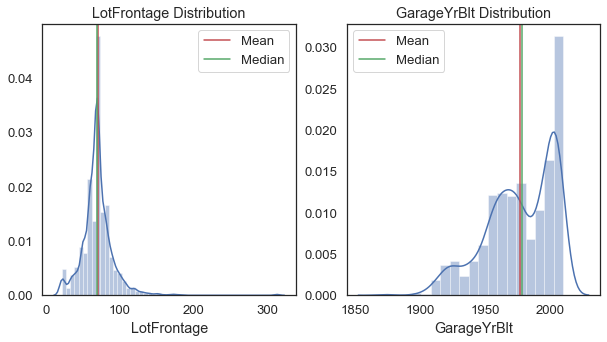

In [579]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(train["LotFrontage"].dropna(), ax=ax[0])
ax[0].axvline(x=train["LotFrontage"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[0].axvline(x=train["LotFrontage"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[0].legend()
ax[0].set_title("LotFrontage Distribution")


sns.distplot(train["GarageYrBlt"].dropna(), ax=ax[1])
ax[1].axvline(x=train["GarageYrBlt"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[1].axvline(x=train["GarageYrBlt"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[1].legend()
ax[1].set_title("GarageYrBlt Distribution")

plt.show()

**Remove/Fix Outliers**

There are potentially many outliers in the data, however, here, I will address only what I see as the biggest offenders. 

First, the `GrLivArea` outliers that are mentioned in the [author's original paper](http://jse.amstat.org/v19n3/decock.pdf) on pg. 4; let's follow the author's advice and remove the unusual homes that are more than 4000 square feet and less than \\$300,000. These points clearly do not follow the trend of the remaining data.

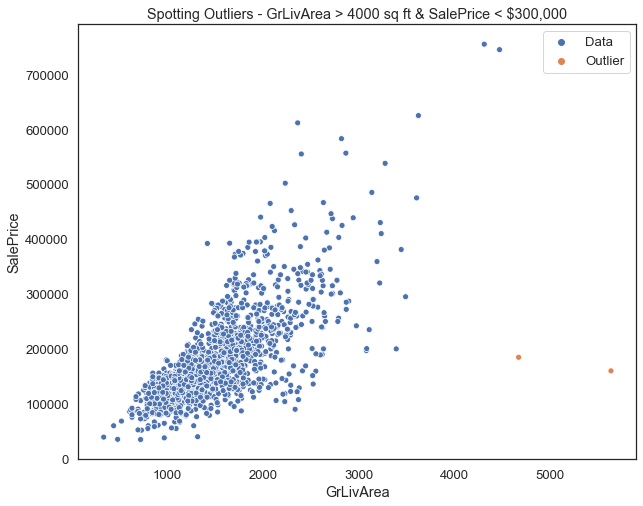

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,None,None,None,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,None,None,0,1,2008,New,Partial,160000


In [580]:
mask = (train["GrLivArea"] > 4000) & (train["SalePrice"] < 300_000)
mask = mask.replace(to_replace=[1, 0], value=["Outlier", "Data"])
sns.scatterplot(x=train["GrLivArea"], y=train["SalePrice"], hue=mask)
plt.title("Spotting Outliers - GrLivArea > 4000 sq ft & SalePrice < $300,000")
plt.show()

train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300_000)]

In addition to the `GrLivArea` outliers, I found several notebooks citing additional outliers. I attempted to  recreate the code that generated their selections (using something called the Bonferroni test), however I struggled to come to the same conclusions. Would love to hear about your outlier selection process in the comments.

In [581]:
# https://www.kaggle.com/fiorenza2/journey-to-the-top-10
outliers = [88, 462, 523, 588, 632, 968, 1298, 1324]
train = train.drop(outliers)

Next, let's fix the `GarageYrBlt` value for one particular house in the test set by assuming that 2207 is supposed to be 2007.

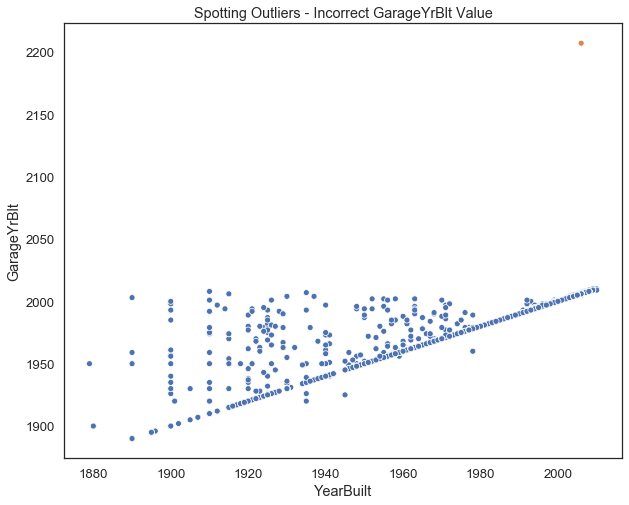

In [582]:
mask = test["GarageYrBlt"] == 2207
sns.scatterplot(x=test["YearBuilt"], y=test["GarageYrBlt"], hue=mask, legend=False)
plt.title("Spotting Outliers - Incorrect GarageYrBlt Value")
plt.show()

In [583]:
# Assume that 2207 was meant to be 2007
test.loc[test["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

**Convert Select Numeric Features to Categorical Features**

Some of the numerical features are actually categorical. While I found that converting `MSSubClass` improved model performance, converting `MoSold` did not.

In [584]:
# By making these substitutions, the columns are automatically cast to datatype object   
for df in [train, test]:
    df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                               50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                               80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                               150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}}, inplace=True)

**Feature Engineering**

Feature engineering allows us to create new features using existing data.

In [585]:
# https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
for df in [train, test]:
    df = df.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
    
    df['BsmtFinType1_Unf'] = 1*(df['BsmtFinType1'] == 'Unf')
    df['HasWoodDeck'] = (df['WoodDeckSF'] == 0) * 1
    df['HasOpenPorch'] = (df['OpenPorchSF'] == 0) * 1
    df['HasEnclosedPorch'] = (df['EnclosedPorch'] == 0) * 1
    df['Has3SsnPorch'] = (df['3SsnPorch'] == 0) * 1
    df['HasScreenPorch'] = (df['ScreenPorch'] == 0) * 1
    df['YearsSinceRemodel'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)
    df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
    df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
    df['TotalBsmtSF'] = df['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    df['2ndFlrSF'] = df['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    df['GarageArea'] = df['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    df['GarageCars'] = df['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    df['LotFrontage'] = df['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    df['MasVnrArea'] = df['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

**Bucketing Features**

It's important that we handle each different type of feature correctly:

* Ordinal features: replace with ordered labels
* Categorical features: one-hot encode
* Numeric features: correct for skew and scale

In [586]:
numeric_features = np.array([c for c in train.select_dtypes(include=[np.number]).columns if c != "SalePrice"])
numeric_features

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
       'YrSold'], dtype='<U13')

In [587]:
categorical_features = np.array(train.select_dtypes(include=[np.object]).columns)
categorical_features

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'], dtype=object)

In [588]:
ordinal_features = ["ExterQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
                "LandSlope", "ExterCond", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", 
                "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "LotShape", "Utilities"]
nominal_features = list(set(categorical_features) - set(ordinal_features))

**LabelEncode the Ordinal Features**

Using the data description file, we can determine which categorical columns refer to ordinal characteristics and replace feature values with ordered numbers. The reason we choose to do this manually (and don't use something like LabelEncoder) is because we want to be able to control the ordering of features, i.e. be able to specify which value corresponds with 0, which value corresponds with 1 etc.

In [589]:
for df in [train, test]:
    df.replace({"BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "BsmtExposure" : {"None" : 0, "No": 0, "Mn" : 1, "Av": 2, "Gd" : 3},
               "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
               "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
               "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
               "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
               "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
               "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
               "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
               "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
               "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
               "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
               "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                , inplace=True)
    
    df[ordinal_features] = df[ordinal_features].astype('int64')

**One-Hot Encode the Nominal Features**

One-hot encoding transforms one column (feature) into many "dummy" columns, one for each unique category/value.

Concat the appropriate train and test observations, so that we produce uniform columns between datasets:

In [590]:
nominal_data = pd.concat([train[nominal_features], test[nominal_features]])
nominal_data.head()

,Condition2,MiscFeature,Street,Neighborhood,GarageType,RoofStyle,CentralAir,MSSubClass,Fence,BldgType,Condition1,LotConfig,Foundation,Heating,Exterior1st,MSZoning,Alley,Electrical,PavedDrive,LandContour,MasVnrType,SaleCondition,HouseStyle,SaleType,RoofMatl,Exterior2nd
0,Norm,None,Pave,CollgCr,Attchd,Gable,Y,SC60,None,1Fam,Norm,Inside,PConc,GasA,VinylSd,RL,None,SBrkr,Y,Lvl,BrkFace,Normal,2Story,WD,CompShg,VinylSd
1,Norm,None,Pave,Veenker,Attchd,Gable,Y,SC20,None,1Fam,Feedr,FR2,CBlock,GasA,MetalSd,RL,None,SBrkr,Y,Lvl,None,Normal,1Story,WD,CompShg,MetalSd
2,Norm,None,Pave,CollgCr,Attchd,Gable,Y,SC60,None,1Fam,Norm,Inside,PConc,GasA,VinylSd,RL,None,SBrkr,Y,Lvl,BrkFace,Normal,2Story,WD,CompShg,VinylSd
3,Norm,None,Pave,Crawfor,Detchd,Gable,Y,SC70,None,1Fam,Norm,Corner,BrkTil,GasA,Wd Sdng,RL,None,SBrkr,Y,Lvl,None,Abnorml,2Story,WD,CompShg,Wd Shng
4,Norm,None,Pave,NoRidge,Attchd,Gable,Y,SC60,None,1Fam,Norm,FR2,PConc,GasA,VinylSd,RL,None,SBrkr,Y,Lvl,BrkFace,Normal,2Story,WD,CompShg,VinylSd


In [591]:
train.shape, test.shape, nominal_data.shape

((1452, 80), (1459, 79), (2911, 26))

In [592]:
nominal_data = pd.get_dummies(nominal_data)
nominal_data.head()

,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Street_Grvl,Street_Pave,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,CentralAir_N,CentralAir_Y,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,MSSubClass_SC85,MSSubClass_SC90,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [593]:
train_dummies = nominal_data[:train.shape[0]]
test_dummies = nominal_data[train.shape[0]:]
train_dummies.shape, test_dummies.shape

((1452, 192), (1459, 192))

Join the dummy columns with the numeric and ordinal columns:

In [594]:
y = train["SalePrice"]
train = pd.concat([train[numeric_features], train[ordinal_features], train_dummies], axis=1)
test = pd.concat([test[numeric_features], test[ordinal_features], test_dummies], axis=1)

Verify that we have extracted the correct number of rows for train vs. test. Also make sure that we have the same columns in both sets.

In [14]:
train.shape, test.shape, set(train.columns) - set(test.columns)

((1460, 80), (1459, 79), {'SalePrice'})

**Log-Transform Skewed Numeric Variables**

I read in a few different places that a |skew| > 0.5 is considered "moderately skewed" and have chosen this as my threshold. If you have any input, please leave a comment below.

In [597]:
y = np.log1p(y) # SalePrice
skew_threshold = 0.5 # As a general rule of thumb, |skew| > 0.5 is considered moderately skewed

for df in [train[numeric_features], test[numeric_features]]:
    skewness = df.apply(lambda x: stats.skew(x))
    skewness = skewness[np.abs(skewness) > skew_threshold]
    skewed_cols = skewness.index
    log_transformed_cols = np.log1p(df[skewed_cols])
    df[skewed_cols] = log_transformed_cols
    print("Transforming {} features...".format(len(skewed_cols)))

train[numeric_features] = train[numeric_features].astype('int64')
test[numeric_features] = test[numeric_features].astype('int64')

Transforming 28 features...
Transforming 26 features...


D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Initial Modeling

I chose to create 3 baseline models using different sets of features:

* Numeric only
* Numeric + ordinal
* All features

**Baseline Model Using Numeric Data Only**

In [598]:
def compare_ridge_lasso(X, y):
    ridge_alphas = np.arange(2, 50, 1)
    cv_ridge = [rmse_cv(Ridge(alpha=alpha), X, y).mean() for alpha in ridge_alphas]
    cv_ridge = pd.Series(cv_ridge, index=ridge_alphas)
    best_alpha_ridge = ridge_alphas[np.argmin(cv_ridge.values)]

    lasso_alphas = np.arange(0.0001, 0.005, 0.0002)
    cv_lasso = [rmse_cv(Lasso(alpha=alpha, tol=0.1), X, y).mean() for alpha in lasso_alphas]
    cv_lasso = pd.Series(cv_lasso, index=lasso_alphas)
    best_alpha_lasso = lasso_alphas[np.argmin(cv_lasso.values)]
    
    print("Best RMSE for Ridge Regression = {:.4f} for alpha = {}".format(cv_ridge.min(), best_alpha_ridge))
    print("Best RMSE for Lasso Regression = {:.4f} for alpha = {}".format(cv_lasso.min(), best_alpha_lasso))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    
    sns.lineplot(x=ridge_alphas, y=cv_ridge, ax=ax[0])
    ax[0].set_title("Ridge Regression - Alpha Optimization")
    ax[0].set_xlabel("Alpha")
    ax[0].set_ylabel("RMSE")
    
    sns.lineplot(x=lasso_alphas, y=cv_lasso, ax=ax[1])
    ax[1].set_title("Lasso Regression - Alpha Optimization")
    ax[1].set_xlabel("Alpha")
    ax[1].set_ylabel("RMSE")
    
    plt.tight_layout()
    plt.show()
    
    return Ridge(alpha=best_alpha_ridge) if cv_ridge.min() < cv_lasso.min() else Lasso(alpha=best_alpha_lasso)

Best RMSE for Ridge Regression = 0.1240 for alpha = 3
Best RMSE for Lasso Regression = 0.1247 for alpha = 0.0007000000000000001


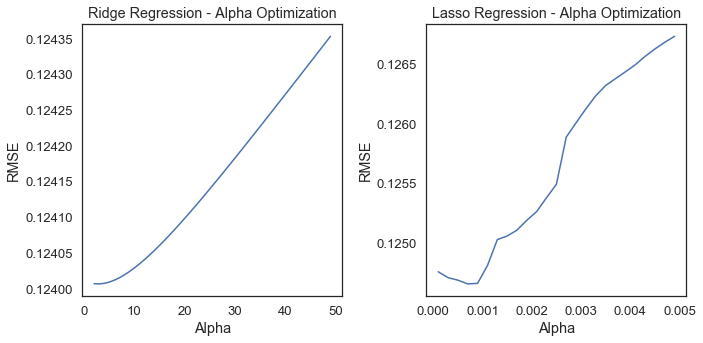

In [599]:
numeric_model = compare_ridge_lasso(train[numeric_features], y)

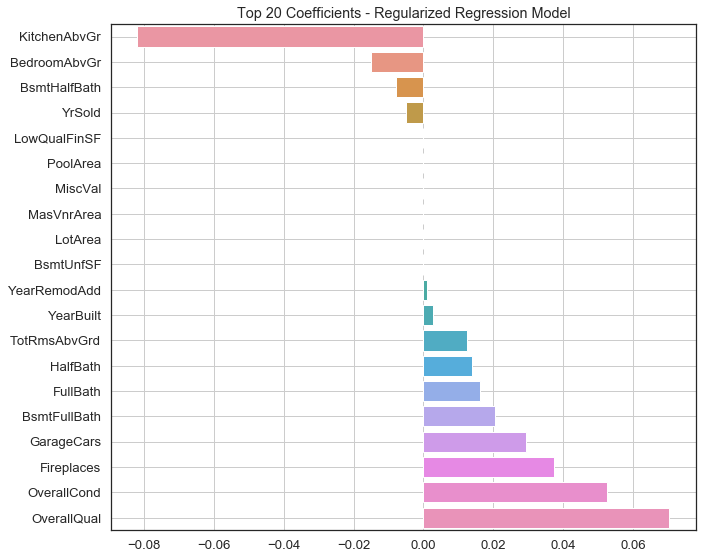

In [600]:
numeric_model.fit(train[numeric_features], y)
plot_coefs(numeric_model, train[numeric_features])

**2nd Model Using Numeric & Ordinal Features**

Best RMSE for Ridge Regression = 0.1203 for alpha = 33
Best RMSE for Lasso Regression = 0.1225 for alpha = 0.0021000000000000003


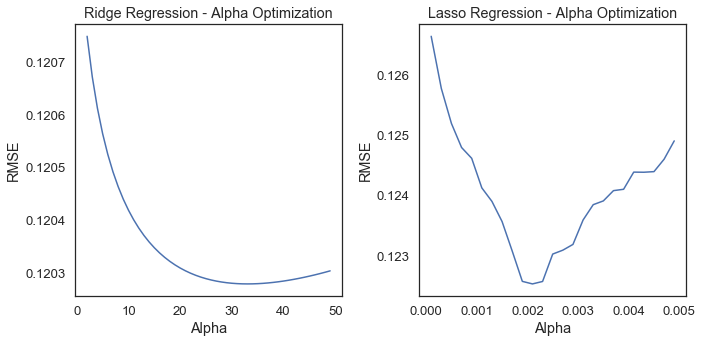

Ridge(alpha=33, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [601]:
numeric_ordinal_features = np.append(numeric_features, ordinal_features)
numeric_ordinal_model = compare_ridge_lasso(train[numeric_ordinal_features], y)
numeric_ordinal_model.fit(train[numeric_ordinal_features], y)

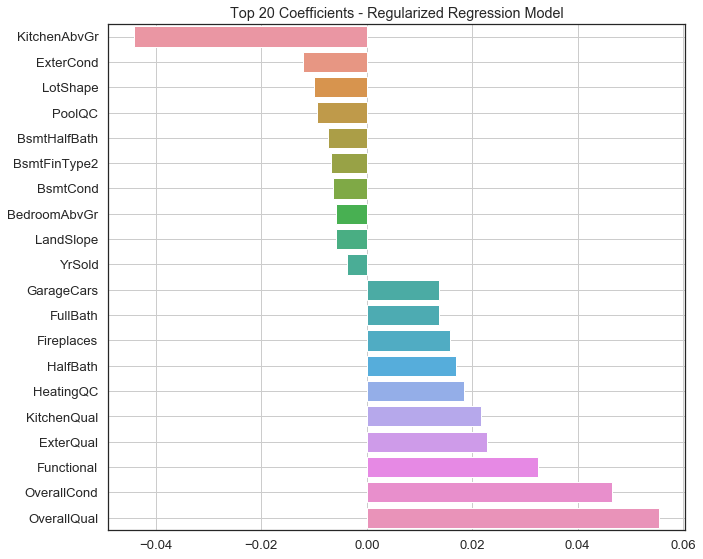

In [602]:
plot_coefs(numeric_ordinal_model, train[numeric_ordinal_features])

**3rd Model Using All Features (Numeric, Ordinal & Nominal)**

Best RMSE for Ridge Regression = 0.1051 for alpha = 9
Best RMSE for Lasso Regression = 0.1145 for alpha = 0.0015000000000000002


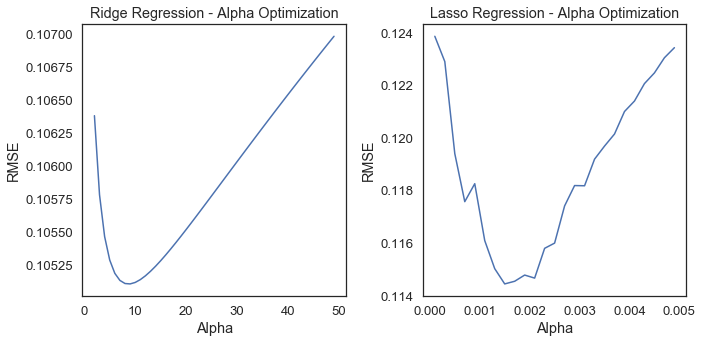

Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [603]:
full_model = compare_ridge_lasso(train, y)
full_model.fit(train, y)

In [604]:
# Baseline model predictions:
output = generate_output(preds, False)
output.sort_values(by="SalePrice", ascending=False).head()

,Id,SalePrice
1089,2550,1.896702e+06
203,1664,5.820576e+05
1222,2683,5.601602e+05
217,1678,5.434551e+05
514,1975,5.397650e+05


**Compare Predicted Price Distribution with Training Distribution**

How do our predictions compare with the actual house prices in the training data?

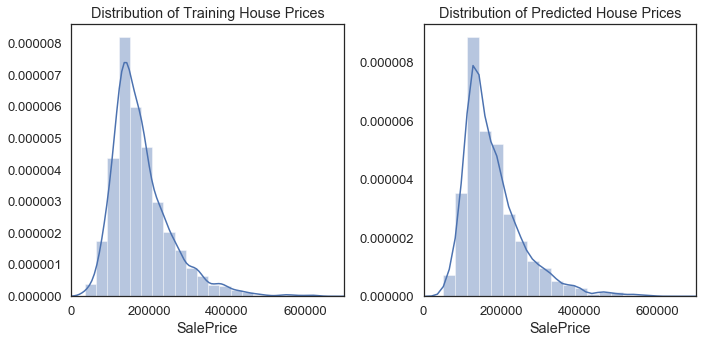

In [605]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(train_["SalePrice"], bins=25, ax=ax[0])
ax[0].set_title("Distribution of Training House Prices")
ax[0].set_xlim([0,700000])

sns.distplot(output["SalePrice"], bins=60, ax=ax[1])
ax[1].set_title("Distribution of Predicted House Prices")
ax[1].set_xlim([0,700000])

plt.tight_layout()
plt.show()

By plotting the top coefficients, we can get an idea of which features the model deems important.

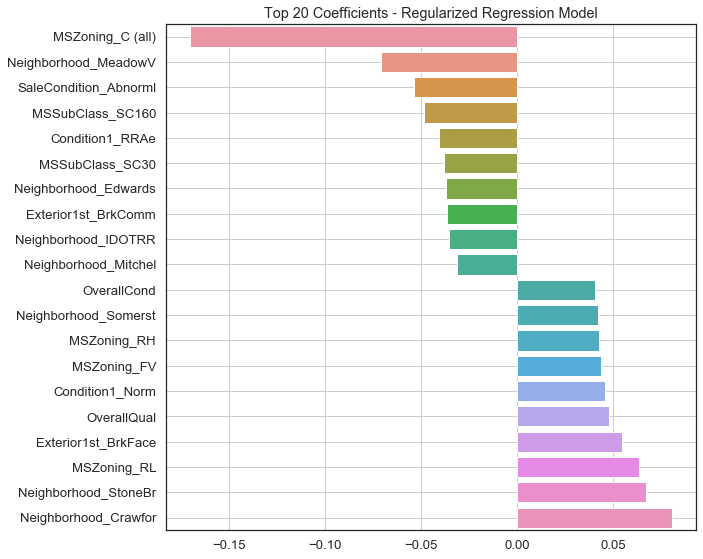

In [606]:
plot_coefs(full_model, train)

**Drop Additional Columns**

We want to remove columns corresponding to categorical features that are particularly rare. This helps to prevent the model from overfitting on features that aren't present in both train and test.

In [607]:
# https://www.kaggle.com/humananalog/xgboost-lasso
cols_to_drop = ["MSZoning_C (all)", "MSSubClass_SC160", "Condition2_PosN", "Exterior1st_ImStucc",
                "RoofMatl_Membran", "RoofMatl_Metal", "RoofMatl_Roll", "Condition2_RRAe", 
                "Condition2_RRAn", "Condition2_RRNn", "Heating_Floor", "Heating_OthW", 
                "Electrical_Mix", "MiscFeature_TenC", "MSSubClass_SC150", "Exterior1st_Stone",
                "Exterior2nd_Other", "HouseStyle_2.5Fin"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

### Evaluate Models

**Baseline Scores**

Rather than splitting the data using `train_test_split`, let's use `cross_val_score` to evaluate our models. The benefit of this approach is that each observation will be used in both train and test, which is critical when dealing with limited input data.

In [608]:
ridge = Ridge(random_state=SEED)
lasso = Lasso(random_state=SEED)
elnt = ElasticNet(random_state=SEED)
kr = KernelRidge()
svr = SVR()
knn = KNeighborsRegressor(n_jobs=-1)
pls = PLSRegression()
dt = DecisionTreeRegressor(random_state=SEED)
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
gb = GradientBoostingRegressor(random_state=SEED)
xgb = XGBRegressor(random_state=SEED, n_jobs=-1, objective="reg:squarederror")

models = [("Ridge", ridge), ("Lasso", lasso), ("ElasticNet", elnt), ("KernelRidge", kr), \
          ("SVR", svr), ("KNNeighbors", knn), ("PLS", pls), ("DecisionTree", dt), ("RandomForest", rf), \
          ("GradientBoosting", gb), ("XGBoost", xgb)]

Create one dataframe to hold of our model scores:

In [609]:
hyperparam_df = pd.DataFrame(index=[m[0] for m in models],
                             columns=["Baseline Score - StandardScaler", "Baseline Score - RobustScaler", 
                                      "Best Score", "Best Params"])

Baseline model evaluation using `StandardScaler()`:

In [610]:
rmses = []
for model in models:
    pipeline = make_pipeline(StandardScaler(), model[1])
    print("Scoring {}...".format(model[0]))
    rmse = np.round(np.sqrt(-cross_val_score(pipeline, train, y, scoring="neg_mean_squared_error", cv=5)).mean(), 3)
    rmses.append(rmse)
    hyperparam_df.loc[model[0], "Baseline Score - StandardScaler"] = rmse

Scoring Ridge...
Scoring Lasso...
Scoring ElasticNet...
Scoring KernelRidge...
Scoring SVR...
Scoring KNNeighbors...
Scoring PLS...
Scoring DecisionTree...
Scoring RandomForest...
Scoring GradientBoosting...
Scoring XGBoost...


D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Baseline model evaluation using `RobustScaler()`:

In [611]:
rmses_robust = []
for model in models:
    pipeline = make_pipeline(RobustScaler(), model[1])
    print("Scoring {}...".format(model[0]))
    rmse = np.round(np.sqrt(-cross_val_score(pipeline, train, y, scoring="neg_mean_squared_error", cv=5)).mean(), 3)
    rmses_robust.append(rmse)
    hyperparam_df.loc[model[0], "Baseline Score - RobustScaler"] = rmse

Scoring Ridge...
Scoring Lasso...
Scoring ElasticNet...
Scoring KernelRidge...
Scoring SVR...
Scoring KNNeighbors...
Scoring PLS...
Scoring DecisionTree...
Scoring RandomForest...
Scoring GradientBoosting...
Scoring XGBoost...


D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Notice how using `RobustScaler` significantly reduced the RMSE for the KernelRidge model while increasing RMSE for SVR and KNN.

In [612]:
hyperparam_df

,Baseline Score - StandardScaler,Baseline Score - RobustScaler,Best Score,Best Params
Ridge,0.114,0.108,NaN,NaN
Lasso,0.397,0.392,NaN,NaN
ElasticNet,0.397,0.391,NaN,NaN
KernelRidge,12.028,0.259,NaN,NaN
SVR,0.179,0.357,NaN,NaN
KNNeighbors,0.194,0.245,NaN,NaN
PLS,0.125,0.125,NaN,NaN
DecisionTree,0.19,0.19,NaN,NaN
RandomForest,0.132,0.132,NaN,NaN
GradientBoosting,0.118,0.118,NaN,NaN


In [613]:
hyperparam_df[["Baseline Score - StandardScaler", "Baseline Score - RobustScaler"]] = hyperparam_df[["Baseline Score - StandardScaler", "Baseline Score - RobustScaler"]].astype('float64')

We can view log(RMSEs) on plot to get a better sense of how the choice of scaler influences model performance. 

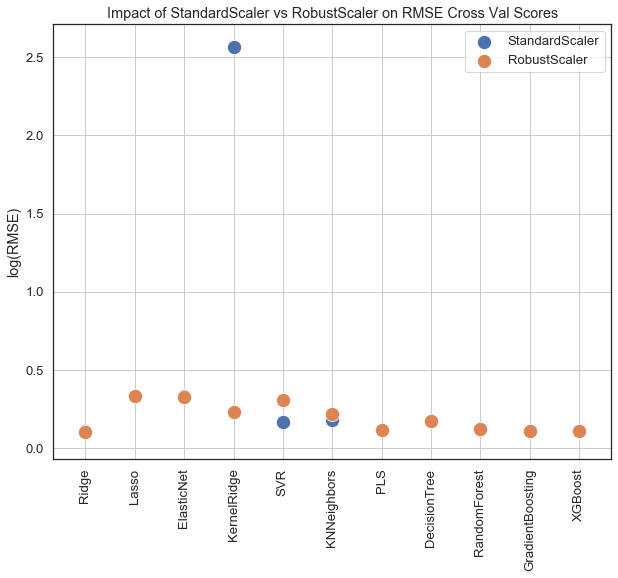

In [614]:
fig, ax = plt.subplots()
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Baseline Score - StandardScaler"]), s=200, label="StandardScaler", ax=ax)
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Baseline Score - RobustScaler"]), s=200, label="RobustScaler", ax=ax)
plt.title("Impact of StandardScaler vs RobustScaler on RMSE Cross Val Scores")
plt.ylabel("log(RMSE)")
plt.xticks(rotation=90)
ax.grid()
plt.show()

Narrowing our focus, we can look at the RMSEs for the `RobustScaler` results alone.

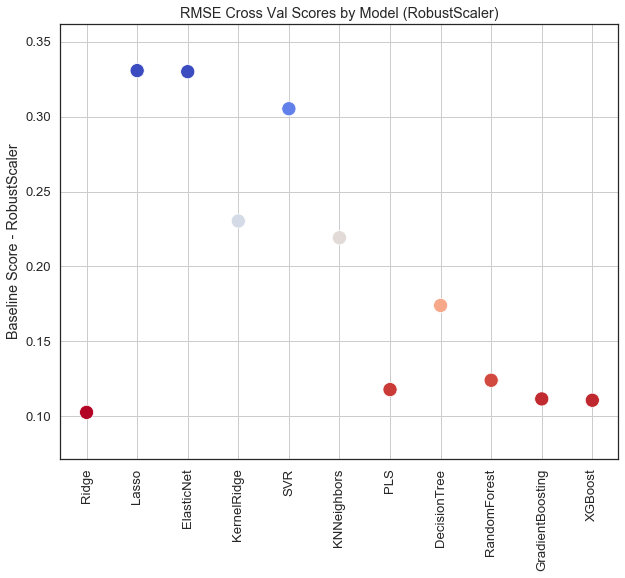

In [615]:
fig, ax = plt.subplots()
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Baseline Score - RobustScaler"]), s=200, hue=hyperparam_df["Baseline Score - RobustScaler"], palette='coolwarm_r', legend=False, ax=ax)
plt.title("RMSE Cross Val Scores by Model (RobustScaler)")
plt.xticks(rotation=90)
ax.grid()
plt.show()

### Optimize Hyperparameters

The goal of hyperparameter optimization is to improve the performance of our models (decrease bias). However, we have to be careful not to overfit the data. 

Note that I selected either `StandardScaler` or `RobustScaler` based on the initial baseline scores.

Optimized parameters are provided to cut down on runtime.

**Ridge**

In [616]:
ridge_param_grid = {"alpha": np.arange(5, 30, 1), 
                    "random_state": [SEED]}

# Optimized Params:
ridge_param_grid = {'alpha': [14], 'random_state': [42]}

ridge = Ridge()
ridge_best_params, ridge_best_score = tune_hyperparameters("Ridge", ridge, ridge_param_grid, RobustScaler())
ridge_best_params, ridge_best_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished


({'alpha': 14, 'random_state': 42}, 0.10699)

**Lasso**

In [617]:
lasso_param_grid = {"alpha": np.arange(0.0001, 0.001, .00002), 
                    "random_state": [SEED]}

# Optimized Params:
lasso_param_grid = {'alpha': [0.00092], 'random_state': [42]}

lasso = Lasso()
lasso_best_params, lasso_best_score = tune_hyperparameters("Lasso", lasso, lasso_param_grid, StandardScaler())
lasso_best_params, lasso_best_score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'alpha': 0.00092, 'random_state': 42}, 0.10655)

**ElasticNet**

In [618]:
elnt_param_grid = {"alpha": [0.0001, 0.0002, 0.0003, 0.01, 0.1, 2], 
                      "l1_ratio": [0.2, 0.85, 0.95, 0.98, 1], 
                      "random_state": [SEED]}

# Optimized Params:
elastic_param_grid = {'alpha': [0.0002], 'l1_ratio': [1], 'random_state': [42]}

elnt = ElasticNet()
elnt_best_params, elnt_best_score = tune_hyperparameters("ElasticNet", elnt, elnt_param_grid, RobustScaler())
elnt_best_params, elnt_best_score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.7s finished


({'alpha': 0.0002, 'l1_ratio': 1, 'random_state': 42}, 0.10427)

**KernelRidge**

In [619]:
kr_param_grid = {"alpha": [0.25, 0.4, 0.5, 0.6, 0.75, 1], 
                     "kernel": ["linear", "polynomial"], "degree": [2, 3], "coef0": [1.5, 2, 3]}

# Optimized Params:
kernel_param_grid = {'alpha': [0.25], 'coef0': [1.5], 'degree': [2], 'kernel': ['linear']}

kr = KernelRidge()
kr_best_params, kr_best_score = tune_hyperparameters("KernelRidge", kr, kr_param_grid, RobustScaler())
kr_best_params, kr_best_score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    6.8s finished


({'alpha': 0.25, 'coef0': 1.5, 'degree': 2, 'kernel': 'linear'}, 0.20709)

**DecisionTree**

In [620]:
dt_param_grid = {"max_depth": [3, 4, 5],
                "min_samples_leaf": [2, 3, 4],
                "min_samples_split": [3, 4, 5],
                "random_state": [SEED]}

# Optimized Params:
dt_param_grid = {'max_depth': [5],
                 'min_samples_leaf': [4],
                 'min_samples_split': [3],
                 'random_state': [42]}

dt = RandomForestRegressor()
dt_best_params, dt_best_score = tune_hyperparameters("DecisionTree", dt, dt_param_grid, StandardScaler())
dt_best_params, dt_best_score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


({'max_depth': 5,
  'min_samples_leaf': 4,
  'min_samples_split': 3,
  'random_state': 42},
 0.15185)

**RandomForest**

In [639]:
rf_param_grid = {"n_estimators": [50, 100, 500, 1000], 
                "max_depth": [1, 2, 3, 4, 5],
                "min_samples_leaf": [2, 3, 4],
                "min_samples_split": [3, 4, 5],
                "random_state": [SEED]}

# Optimized Params:
rf_param_grid = {}

rf = RandomForestRegressor()
rf_best_params, rf_best_score = tune_hyperparameters("RandomForest", rf, rf_param_grid, StandardScaler())
rf_best_params, rf_best_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.1s finished


({}, 0.13282)

**KNN**

In [622]:
knn_param_grid = {"n_neighbors": [3, 4, 5, 6], 
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [10, 20, 30, 40, 50],
                "p": [1, 2]}

# Optimized Params:
knn_param_grid = {'algorithm': ['auto'], 'leaf_size': [10], 'n_neighbors': [4], 'p': [1]}

knn = KNeighborsRegressor()
knn_best_params, knn_best_score = tune_hyperparameters("KNNeighbors", knn, knn_param_grid, StandardScaler())
knn_best_params, knn_best_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished


({'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 4, 'p': 1}, 0.17387)

**XGBoost**

In [623]:
xgb_param_grid = {"colsample_bytree": [0.1, 0.2],
                 "learning_rate": [0.01, 0.05],
                 "max_depth": [3, 4],
                 "n_estimators": [2000],
                 "random_state": [42]}

# Optimized Params:
xgb_param_grid = {'colsample_bytree': [0.2], 'learning_rate': [0.01], 'max_depth': [4], 'n_estimators': [2000], 'random_state': [42]}

xgb = XGBRegressor(n_jobs=-1, objective="reg:squarederror")
xgb_best_params, xgb_best_score = tune_hyperparameters("XGBoost", xgb, xgb_param_grid, StandardScaler())
xgb_best_params, xgb_best_score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.8s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.6s finished
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


({'colsample_bytree': 0.2,
  'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 2000,
  'random_state': 42},
 0.10861)

**SVR**

In [624]:
svr_param_grid = {"C": [20, 30, 40, 50, 60, 70],
                 "epsilon": [0.1, 0.01, 0.001],
                 "gamma": [0.0005, 0.0001, 0.00005]}

# Optimized Params:
svr_param_grid = {'C': [50], 'epsilon': [0.01], 'gamma': [0.0001]}

svr = SVR()
svr_best_params, svr_best_score = tune_hyperparameters("SVR", svr, svr_param_grid, StandardScaler())
svr_best_params, svr_best_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.9s finished


({'C': 50, 'epsilon': 0.01, 'gamma': 0.0001}, 0.10749)

**PLS**

In [625]:
pls_param_grid = {"n_components": [2, 3, 4, 5]}

# Optimized Params:
pls_param_grid = {"n_components": [5]}

pls = PLSRegression()
pls_best_params, pls_best_score = tune_hyperparameters("PLS", pls, pls_param_grid, StandardScaler())
pls_best_params, pls_best_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


({'n_components': 5}, 0.1153)

**GradientBoosting**

In [626]:
gb_param_grid = {"n_estimators": [1000, 3000],
                "learning_rate": [0.01],
                "max_depth": [4],
                "loss": ["huber"],
                "max_features": ["sqrt"],
                "min_samples_leaf": [15],
                "min_samples_split": [10]}

# Optimized Params:
gb_param_grid = {'learning_rate': [0.01],
                 'loss': ['huber'],
                 'max_depth': [4],
                 'max_features': ['sqrt'],
                 'min_samples_leaf': [15],
                 'min_samples_split': [10],
                 'n_estimators': [3000]}

gb = GradientBoostingRegressor()
gb_best_params, gb_best_score = tune_hyperparameters("GradientBoosting", gb, gb_param_grid, StandardScaler())
gb_best_params, gb_best_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.6s finished


({'learning_rate': 0.01,
  'loss': 'huber',
  'max_depth': 4,
  'max_features': 'sqrt',
  'min_samples_leaf': 15,
  'min_samples_split': 10,
  'n_estimators': 3000},
 0.10693)

**Compare Optimized to Baseline Scores**

Hopefully, by performing hyperparameter optimization, we have succeeded in decreasing the RMSEs of our collection of models.

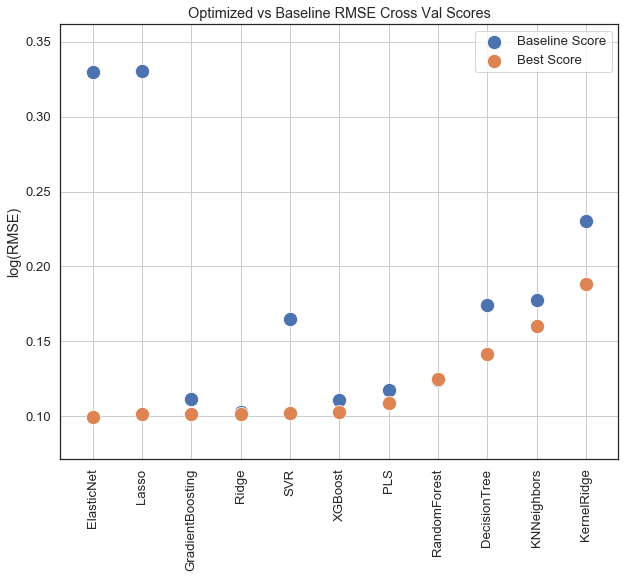

In [643]:
hyperparam_df[["Best Score"]] = hyperparam_df[["Best Score"]].astype('float64')
best_baseline_scores = np.min(hyperparam_df[["Baseline Score - StandardScaler", "Baseline Score - RobustScaler"]], axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(best_baseline_scores), s=200, label="Baseline Score", ax=ax)
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Best Score"]), s=200, label="Best Score", ax=ax)
plt.title("Optimized vs Baseline RMSE Cross Val Scores")
plt.ylabel("log(RMSE)")
plt.xticks(rotation=90)
ax.grid()
plt.show()

**Combine Top Scoring Models**

I found that the using multiple models and averaging their predictions resulted in the best leaderboard score. This is likely due to the overfitting of one model offsetting the underfitting of another model. 

In [640]:
hyperparam_df.sort_values(by="Best Score", inplace=True)
hyperparam_df

,Baseline Score - StandardScaler,Baseline Score - RobustScaler,Best Score,Best Params
ElasticNet,0.397,0.391,0.10427,"{'alpha': 0.0002, 'l1_ratio': 1, 'random_state..."
Lasso,0.397,0.392,0.10655,"{'alpha': 0.00092, 'random_state': 42}"
GradientBoosting,0.118,0.118,0.10693,"{'learning_rate': 0.01, 'loss': 'huber', 'max_..."
Ridge,0.114,0.108,0.10699,"{'alpha': 14, 'random_state': 42}"
SVR,0.179,0.357,0.10749,"{'C': 50, 'epsilon': 0.01, 'gamma': 0.0001}"
XGBoost,0.117,0.117,0.10861,"{'colsample_bytree': 0.2, 'learning_rate': 0.0..."
PLS,0.125,0.125,0.11530,{'n_components': 5}
RandomForest,0.132,0.132,0.13282,{}
DecisionTree,0.190,0.190,0.15185,"{'max_depth': 5, 'min_samples_leaf': 4, 'min_s..."
KNNeighbors,0.194,0.245,0.17387,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig..."


### Generate Predictions

I experimented with a variety of different model combinations to varying success on the leaderboard.

My final average model is comprised of:

* Lasso + `RobustScaler`
* SVR + `StandardScaler`
* XGBoost Ensemble + `StandardScaler`

If you tried averaging and found a different winning combination, let me know below.

In [628]:
# Lasso
scaler = RobustScaler()
lasso = Lasso(**lasso_best_params)
lasso.fit(scaler.fit_transform(train), y)
predictions_lasso = np.expm1(lasso.predict(scaler.transform(test)))

# SVR
scaler = StandardScaler()
svr = SVR(**svr_best_params)
svr.fit(scaler.fit_transform(train), y)
predictions_svr = np.expm1(svr.predict(scaler.transform(test)))

# XGB
# https://www.kaggle.com/fiorenza2/journey-to-the-top-10
scaler = StandardScaler()
_ = xgb_best_params.pop("random_state") if "random_state" in xgb_best_params else ""
xgb1 = XGBRegressor(**xgb_best_params, random_state = 42)
xgb2 = XGBRegressor(**xgb_best_params, random_state = 6666)
xgb3 = XGBRegressor(**xgb_best_params, random_state = 0)
xgb_ensemble = CustomEnsembleRegressor([xgb1, xgb2, xgb3])
xgb_ensemble.fit(scaler.fit_transform(train), y)
predictions_xgb = np.expm1(xgb_ensemble.predict(scaler.transform(test)))

# Collate Predictions
predictions = pd.concat([pd.Series(predictions_lasso), 
                         pd.Series(predictions_svr), 
                         pd.Series(predictions_xgb)], axis=1).head()
predictions.columns = ["Lasso", "SVR", "XGBoost"]

D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:27:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [629]:
predictions.head()

,ElasticNet,GradientBoosting,Lasso,SVR,XGBoost
0,119033.322953,123366.632346,113334.461583,121029.162554,123154.945312
1,153125.462846,158922.875580,151371.515665,160078.698823,157603.203125
2,178532.936558,190443.959269,177413.647818,189827.442022,187562.625000
3,200591.530850,193773.189050,200171.717306,200723.190984,193058.453125
4,195500.905420,191041.977860,188141.646193,186826.159588,187335.578125


In [630]:
# Average Predictions
predictions_avg = (predictions_lasso + predictions_svr + predictions_xgb) / 3
output = generate_output(predictions_avg, save=True)
output.head()

,Id,SalePrice
0,1461,119172.856483
1,1462,156351.139204
2,1463,184934.571613
3,1464,197984.453805
4,1465,187434.461302


### Conclusion

I learned so much from this challenge, including:

* Cross validation isn't the be-all end-all. This is a small dataset, so the fantastic CV scores you're getting on the training data will likely not translate to the official leaderboard.
* Outliers can have a TREMENDOUS impact on model performance. Finding them still seems quite arbitrary to me, which probably means I don't understand it enough.
* Some models perform better/worse using different scalers (ex: `StandardScaler` or `RobustScaler`).
* And on the same note, if you use a scaler, don't forget to transform your test set. This drove me crazy for two days!!

I'd love to know what you think and if you have any suggestions for improvement.

If you're just getting started, please check out my [House Prices EDA notebook](https://www.kaggle.com/amypeniston/house-prices-eda-essentials-for-beginners) to familiarize yourself with the data.

Thanks so much for reading. Until next time, happy coding :)